In [32]:
#wrangling
import pandas as pd
import numpy as np
import janitor
import datetime
from datetime import timedelta

#graphing
import altair as alt
import seaborn as sns
import calendar

#lifetime
import lifetimes
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import lifetimes.plotting

## Load Data

In [2]:
df = pd.read_csv("../data/data.csv", encoding= 'unicode_escape')

In [3]:
df = janitor.clean_names(df)

In [4]:
df.head(1)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom


In [5]:
df['invoicedate_month'] = pd.to_datetime(df['invoicedate']).dt.month
df['invoicedate'] = pd.to_datetime(df['invoicedate']).dt.date

In [6]:
df.head(2)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,invoicedate_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,12


## EDA

In [7]:
df_invoicedate = df.groupby("invoicedate").invoiceno.nunique()

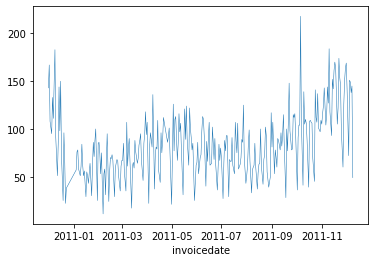

In [8]:
df_invoicedate.plot(linewidth=.5)


In [9]:
df_invoicedate_month = df.groupby("invoicedate_month").invoiceno.nunique()

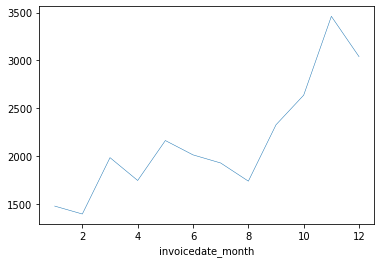

In [10]:
df_invoicedate_month.plot(linewidth=.5)

In [11]:
df.head(1)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,invoicedate_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,12


In [12]:
df_customers = df.groupby('customerid').invoiceno.nunique()

In [13]:
df_customers

customerid
12346.0     2
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     3
18283.0    16
18287.0     3
Name: invoiceno, Length: 4372, dtype: int64

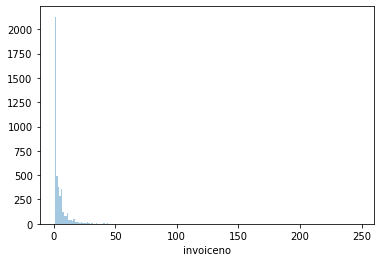

In [14]:
sns.distplot(df_customers, bins=200, kde=False)

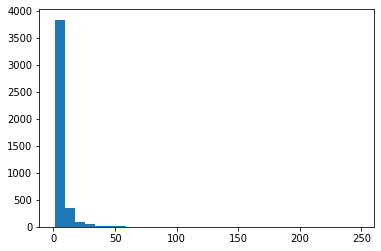

In [15]:
df_customers.hist(bins=30, grid=False)

In [16]:
df_customers = df_customers.to_frame().reset_index()

In [17]:
alt.Chart(df_customers).mark_area().encode(
    alt.X("invoiceno"),
    y="count()",
    tooltip='count()'
).transform_density()

TypeError: transform_density() missing 1 required positional argument: 'density'

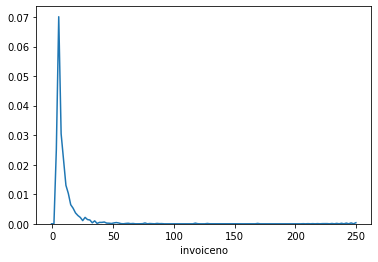

In [18]:
sns.distplot(df_customers['invoiceno'], hist=False)

## Calculate Customer Metrics

- Frequency - number of dates which customer made a purchases subsequent to the date customer's first purchase
- Age (T) - how long a customer has been on the platform from their first purchase 
- Recent when their last purchase was 

In [20]:
current_date = df['invoicedate'].max()
calibration_end_date = current_date - timedelta(days=90)

In [21]:
df_cbs = lifetimes.utils.summary_data_from_transaction_data(
    df,
    customer_id_col='customerid',
    datetime_col='invoicedate',
    observation_period_end=current_date,
    freq='D')

In [22]:

df_cal_cbs = lifetimes.utils.calibration_and_holdout_data(
    df, 
    customer_id_col='customerid',
    datetime_col='invoicedate',
    observation_period_end=current_date,
    calibration_period_end=calibration_end_date,
    freq='D'
)

In [23]:
df_cal_cbs.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customerid,,,,,
12346.0,0.0,0.0,235.0,0.0,90.0
12347.0,4.0,238.0,277.0,2.0,90.0
12348.0,2.0,110.0,268.0,1.0,90.0
12350.0,0.0,0.0,220.0,0.0,90.0
12352.0,3.0,34.0,206.0,3.0,90.0


In [24]:
#remove the frequenice = 0 
df_cal_cbs_filtered = df_cal_cbs[df_cal_cbs['frequency_cal'] > 0]

In [25]:
df_cal_cbs_model = df_cal_cbs_filtered

model_NBD = ParetoNBDFitter(penalizer_coef=0.0)
model_NBD.fit(df_cal_cbs_model['frequency_cal'], df_cal_cbs_model['recency_cal'],df_cal_cbs_model['T_cal'])

/opt/anaconda3/lib/python3.7/site-packages/scipy/special/_logsumexp.py:110: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<lifetimes.ParetoNBDFitter: fitted with 2163 subjects, alpha: 96.97, beta: 581028.54, r: 1.99, s: 155.72>

In [26]:
#get predictions for holdout
frequency_holdout_predicted = model_NBD.predict(df_cal_cbs_model['duration_holdout'],
                                                df_cal_cbs_model['frequency_cal'],
                                                df_cal_cbs_model['recency_cal'],
                                                df_cal_cbs_model['T_cal'])

#get actual frequency during holdout period
frequency_holdout_actual = df_cal_cbs_model['frequency_holdout']

## Evaluating the Model

In [27]:
def score_model(actuals, predicted, metric='mse'):
    metric = metric.lower()
    
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
        if metric == 'rmse':
            val = np.sqrt(val)
        
    elif metric == 'mae':
        np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    
    else:
        val = None
    return val


In [28]:
MSE = score_model(frequency_holdout_actual, frequency_holdout_predicted)

print(f"MSE: {MSE}")

MSE: 4.046115917323927


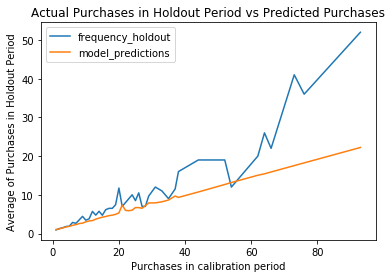

In [29]:
plot_calibration_purchases_vs_holdout_purchases(
    model_NBD,
    df_cal_cbs_model,
    n=90
)

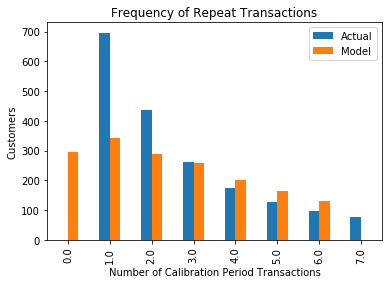

In [40]:
lifetimes.plotting.plot_period_transactions(model_NBD)

/opt/anaconda3/lib/python3.7/site-packages/scipy/special/_logsumexp.py:110: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


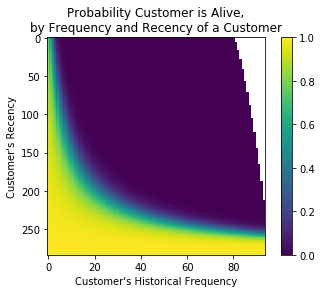

In [41]:
lifetimes.plotting.plot_probability_alive_matrix(model_NBD)

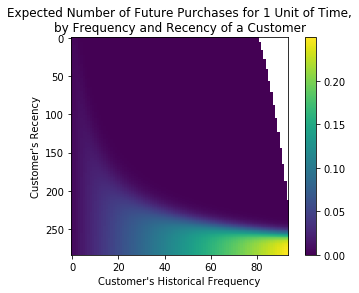

In [42]:
lifetimes.plotting.plot_frequency_recency_matrix(model_NBD)

In [36]:
df_cbs = df_cbs[df_cbs['frequency'] > 0]

#prob alive
df_cbs["prob_alive"] = model_NBD.conditional_probability_alive(df_cbs['frequency'], df_cbs['recency'], df_cbs['T'])

#purchase in the next 15, 30, 45, 60 days
days = [15, 30, 45, 60]

for day in days:
    df_cbs['purchase_next' +str(day)+'days'] = model_NBD.conditional_expected_number_of_purchases_up_to_time(
        day,
        df_cbs['frequency'],
        df_cbs['recency'],
        df_cbs['T'])

In [37]:
df_cbs

,frequency,recency,T,prob_alive,purchase_next15days,purchase_next30days,purchase_next45days,purchase_next60days
customerid,,,,,,,,
12347.0,6.0,365.0,367.0,0.999455,0.257806,0.514578,0.770321,1.025038
12348.0,3.0,283.0,358.0,0.968507,0.159164,0.317690,0.475580,0.632837
12352.0,6.0,260.0,296.0,0.985707,0.300198,0.599192,0.896987,1.193588
12356.0,2.0,303.0,325.0,0.993459,0.140788,0.281012,0.420674,0.559776
12358.0,1.0,149.0,150.0,0.999730,0.181470,0.362212,0.542230,0.721525
...,...,...,...,...,...,...,...,...
18276.0,1.0,22.0,43.0,0.992827,0.317985,0.634693,0.950132,1.264305
18277.0,1.0,260.0,318.0,0.980696,0.105946,0.211467,0.316565,0.421241
18282.0,2.0,119.0,126.0,0.998002,0.267660,0.534247,0.799765,1.064217
